<a href="https://colab.research.google.com/github/ejrtks1020/TensorFlow-CV/blob/main/mnist_GAN_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [2]:
# MNIST 데이터 다운로드
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# 이미지들을 float32 데이터 타입으로 변경
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
# 28*28 형태의 이미지를 784 차원으로 flattening
x_train, x_test = x_train.reshape([-1, 784]), x_test.reshape([-1, 784])
# [0, 255] 사이의 값을 [0,1] 사이의 값으로 Normalize한다.
x_train, x_test = x_train / 255., x_test / 255

11501568/11490434 [==============================] - 0s 0us/step


In [41]:
# 생성된 MNIST 이미지를 8x8 Grid로 보여주는 plot함수
def plot(samples):
  fig = plt.figure(figsize = (8, 8))
  gs = gridspec.GridSpec(8, 8)
  gs.update(wspace = 0.05, hspace = 0.05)

  for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    plt.imshow(sample.reshape(28, 28))

  return fig


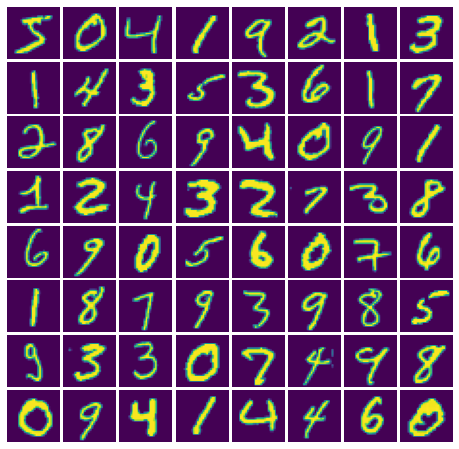

In [40]:
plot(x_train[:64])

In [5]:
# 학습에 필요한 하이퍼 파라미터들을 설정
num_epoch = 100000
batch_size = 64
num_input = 28 * 28
num_latent_variable = 100 # 잠재변수 z의 차원, 100차원의 임의의 noise latent variable 
num_hidden = 128 # hidden layer dimension
learning_rate = 0.001

In [67]:
# tf.data API를 이용해서 데이터를 섞고 batch 형태로 가져옴
train_data = tf.data.Dataset.from_tensor_slices(x_train)
train_data = train_data.repeat().shuffle(60000).batch(batch_size)
train_data_iter = iter(train_data)

In [14]:
# 초기 weight값을 가우시안 분포형태로 할당하도록 하는weight bias initializer 함수
def random_normal_initializer(stddev):
  return tf.keras.initializers.RandomNormal(mean = 0.0, stddev = stddev, seed = None)


In [12]:
#Generator 모델 정의
# Inputs : Latent variable X
# Outputs : 생성된 MNIST 이미지 generated_mnist_image

class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    # 100 -> 128 -> 784
    # 히든 레이어 파라미터
    self.hidden_layer_1 = tf.keras.layers.Dense(num_hidden,
                                               activation = 'relu',
                                               kernel_initializer = random_normal_initializer(5e-2),
                                               bias_initializer = tf.keras.initializers.Constant(value = 0.1))
    # 아웃풋 레이어 파라미터
    self.output_layer = tf.keras.layers.Dense(num_input,
                                              activation = 'sigmoid',
                                              kernel_initializer = random_normal_initializer(5e-2),
                                              bias_initializer = tf.keras.initializers.Constant(value = 0.1))
    
  def call(self, x):
    hidden_layer = self.hidden_layer_1(x)
    generated_mnist_image = self.output_layer(hidden_layer)

    return generated_mnist_image

In [18]:
generator = Generator()
generated = generator(np.random.uniform(-1., 1., [1, 100]).astype('float32')).numpy()

(1, 784)


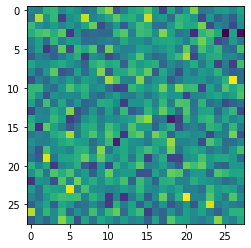

In [22]:
print(generated.shape)
plt.imshow(generated.reshape(28, 28));

In [59]:
# Discriminator 모델정의
# Inputs : 인풋 이미지 X
# Outputs : 
#       predicted_value : Discriminator가 판단한 True(1) or Fake(0)
#       logits : sigmoid를 씌우기전 출력값

class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    # 784 -> 128 -> 1
    # 히든레이어 파라미터
    self.hidden_layer_1 = tf.keras.layers.Dense(num_hidden,
                                                activation='relu',
                                                kernel_initializer = random_normal_initializer(5e-2),
                                                bias_initializer = tf.keras.initializers.Constant(value = 0.1))
    
    # 아웃풋레이어 파라미터
    self.output_layer = tf.keras.layers.Dense(1,
                                              activation = None,
                                              kernel_initializer = random_normal_initializer(5e-2),
                                              bias_initializer = tf.keras.initializers.Constant(value = 0.1))
    
  def call(self, x):
    hidden_layer = self.hidden_layer_1(x)
    logits = self.output_layer(hidden_layer)
    predicted_value = tf.nn.sigmoid(logits)

    return predicted_value, logits


In [60]:
disc = Discriminator()
sample = x_train[0].reshape(-1, 28 * 28)
predicted_value, logits = disc(sample)

In [61]:
predicted_value, logits

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.56923354]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.27872476]], dtype=float32)>)

In [43]:
#Generator 손실 함수 정의
@tf.function
def generator_loss(D_fake_logits):
  return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake_logits, labels = tf.ones_like(D_fake_logits)))

# Discriminator 손실 함수 정의
@tf.function
def discriminator_loss(D_real_logits, D_fake_logits):
  d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_real_logits, labels = tf.ones_like(D_real_logits)))
  d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake_logits, labels = tf.zeros_like(D_fake_logits)))
  d_loss = d_loss_real + d_loss_fake # log(D(x)) + log(1-D(G(z)))

  return d_loss

In [62]:
# 생성자 (Generator) 모델 선언
Generator_model = Generator()

# 구문자 (Discriminator) 모델 선언
Discriminator_model = Discriminator()

# 생성자와 구분자를 위한 Optimizer 정의
discriminator_optimizer = tf.optimizers.Adam(learning_rate)
generator_optimizer = tf.optimizers.Adam(learning_rate)

In [66]:
# Discriminator 최적화를 위한 function 정의
@tf.function
def d_train_step(discriminator_model, real_image, fake_image):
  with tf.GradientTape() as disc_tape:
    D_real, D_real_logits = discriminator_model(real_image) # D(x)
    D_fake, D_fake_logits = discriminator_model(fake_image) # D(G(z))
    loss = discriminator_loss(D_real_logits, D_fake_logits)
  gradients = disc_tape.gradient(loss, discriminator_model.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients, discriminator_model.trainable_variables))

# Generator 최적화를 위한 function 정의
@tf.function
def g_train_step(generator_model, discriminator_model, z):
  with tf.GradientTape() as gen_tape:
    G = generator_model(z)
    D_fake, D_fake_logits = discriminator_model(G) # D(G(z))
    loss = generator_loss(D_fake_logits)
  gradients = gen_tape.gradient(loss, generator_model.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients, generator_model.trainable_variables))

In [47]:
!rm -rf 'generated_output'

In [68]:
# 생성된 이미지들을 저장할 generated_output 폴더 생성
num_img = 0
if not os.path.exists('generated_output'):
  os.makedirs('generated_output')

In [69]:
# num_epoch 만큼 최적화 수행
for i in range(num_epoch):
  # MNIST 이미지를 batch_size만큼 불러온다.
  batch_X = next(train_data_iter)

  # Generator의 인풋으로 사용할 noise(Latent Variable)를 Uniform Distribution에서 batch_size 개수만큼 샘플링
  batch_noise = np.random.uniform(-1., 1., [batch_size, 100]).astype('float32')

  # 500번 반복할때마다 생성된 이미지를 저장
  if i % 500 == 0:
    samples = Generator_model(batch_noise).numpy()
    fig = plot(samples)
    plt.savefig('generated_output/%s.png' % str(num_img).zfill(3), bbox_inches = 'tight')
    num_img += 1
    plt.close(fig)

  # Discriminator 최적화를 수행하고 손실함수를 리턴
  d_train_step(Discriminator_model, batch_X, Generator_model(batch_noise))
  d_loss_print = discriminator_loss(Discriminator_model(batch_X)[1], Discriminator_model(Generator_model(batch_noise))[1])
  
  # Generator 최적화를 수행하고 손실함수를 리턴
  g_train_step(Generator_model, Discriminator_model, batch_noise)
  g_loss_print = generator_loss(Discriminator_model(Generator_model(batch_noise))[1])

  # 1000번 반복할때마다 Discriminator의 손실함수와 Generator의 손실함수 출력
  if i % 1000 == 0:
    print('반복(Epoch): %d, Generator 손실함수(g_loss): %f, Discriminator 손실함수(d_loss): %f' % (i, g_loss_print, d_loss_print))

반복(Epoch): 0, Generator 손실함수(g_loss): 1.032634, Discriminator 손실함수(d_loss): 0.997690
반복(Epoch): 1000, Generator 손실함수(g_loss): 12.284762, Discriminator 손실함수(d_loss): 0.016253
반복(Epoch): 2000, Generator 손실함수(g_loss): 8.761435, Discriminator 손실함수(d_loss): 0.012230
반복(Epoch): 3000, Generator 손실함수(g_loss): 8.584700, Discriminator 손실함수(d_loss): 0.001270
반복(Epoch): 4000, Generator 손실함수(g_loss): 9.094100, Discriminator 손실함수(d_loss): 0.001572
반복(Epoch): 5000, Generator 손실함수(g_loss): 7.992204, Discriminator 손실함수(d_loss): 0.000942
반복(Epoch): 6000, Generator 손실함수(g_loss): 9.442874, Discriminator 손실함수(d_loss): 0.000385
반복(Epoch): 7000, Generator 손실함수(g_loss): 6.455260, Discriminator 손실함수(d_loss): 0.004340
반복(Epoch): 8000, Generator 손실함수(g_loss): 6.992802, Discriminator 손실함수(d_loss): 0.002278
반복(Epoch): 9000, Generator 손실함수(g_loss): 7.188003, Discriminator 손실함수(d_loss): 0.004183
반복(Epoch): 10000, Generator 손실함수(g_loss): 7.747595, Discriminator 손실함수(d_loss): 0.015387
반복(Epoch): 11000, Generator 손실함수(

In [72]:
import glob
generated_imgs = sorted(glob.glob('generated_output/*.png'))

## epoch별 Generated Image 확인

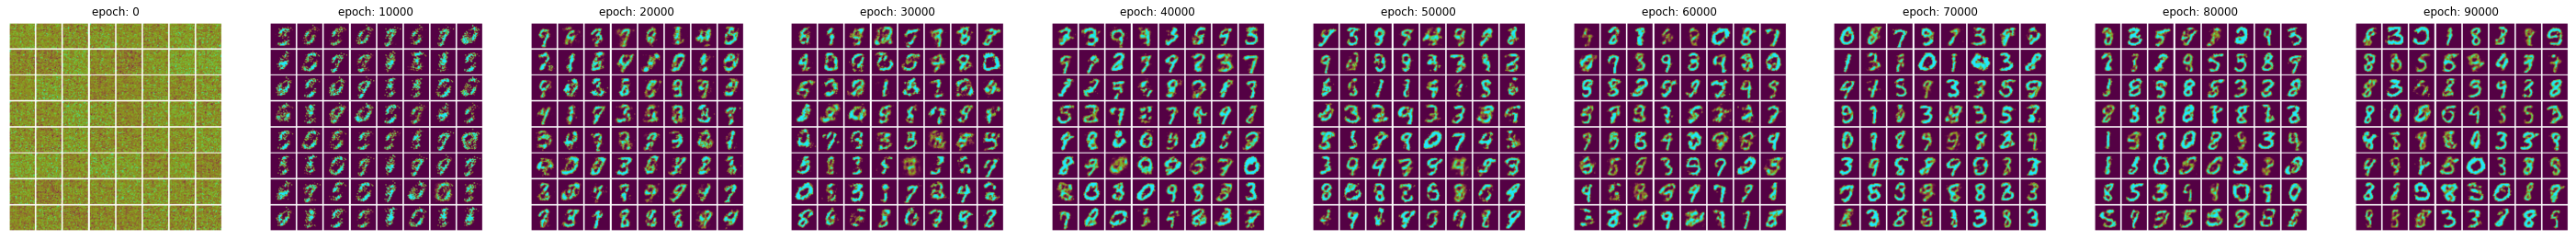

In [91]:
import cv2

fig, ax = plt.subplots(1, 10, figsize = (50, 20))
col = 0
for i in range(len(generated_imgs)):
  if i % 20 == 0:
    ax[col].imshow(cv2.imread(generated_imgs[i]))
    ax[col].set_title('epoch: {}'.format(str(int(generated_imgs[i].split('/')[-1][:-4]) * 500)))
    ax[col].axis('off')
    col += 1
